# Baseline Models Template for 2016 - 2020 Data (exports)
Tidying up "4_baseline_model_export_targetEncoding" as well as adding in resampling options

## Setup

In [1]:
# imports
import pandas as pd
import numpy as np
from datetime import datetime
import xgboost as xgb
from imodels import FIGSClassifier
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
# sklearn
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA, SparsePCA
from sklearn.covariance import empirical_covariance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample

# plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import seaborn as sns
#from adspy_shared_utilities import plot_decision_tree
from adspy_shared_utilities import plot_feature_importances

# create folders and export models
import joblib
import os

In [2]:
# environment variables
rng = 42
p = '../data/'
input_name = 'cleaned.csv'
# change this value to False if you don't want printouts after every model
outputs = False

# set up folder to save results
output_path = 'export_run5_TargetEncoding_resampling'
if not os.path.exists(output_path):
    os.makedirs(output_path)
else:
    print("Folder already exists")
# file name
prefix = 'export_run5_TargetEncoding_resampling/export'

Folder already exists


In [3]:
# helper functions
def df_filtering(df, i_e = 'I', f_cols = []):

    filtered_df = df[df.i_e == i_e]
    filtered_df = filtered_df[f_cols+['act']]

    return filtered_df

def data_split(df):
    X, y = df.iloc[:,:-1], df.iloc[:,-1:]
    y = np.where(y['act']=='R',1,0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng, stratify=y)

    return X_train, X_test, y_train, y_test

def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)

    plt.show()

def plot_pca(pca, f_names, top_k = 10):
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.imshow(pca.components_[0:top_k], interpolation = 'none', cmap = 'plasma')
    feature_names=f_names
    plt.xticks(np.arange(-0., len(feature_names), 1) , feature_names, rotation = 90, fontsize=12)
    plt.yticks(np.arange(0., 2, 1), ['First PC', 'Second PC'], fontsize = 16)
    plt.colorbar()

def upsampler(df_x, df_y): # https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/
    # combine results
    df_x['act'] = df_y
    # filter into majority / minority
    df_majority = df_x.loc[df_x['act']==0]
    df_minority = df_x.loc[df_x['act']==1]
    # upsample to the size of the majority
    df_minority_upsampled = resample(df_minority, replace=True, n_samples= len(df_majority), random_state=rng)
    # combine and split back into x and y dfs
    df_upsampled = pd.concat([df_minority_upsampled, df_majority])
    new_y = df_upsampled['act']
    new_x = df_upsampled.drop(columns=['act'])
    return new_x, new_y

#### Preprocessing

In [4]:
# read in the data
df = pd.read_csv(f'{p}{input_name}')
if outputs:
    print(df.columns)

In [5]:
# modify these columns to adjust what features are used
non_feature_cols = ['control_number', 'disp_date', 'i_e', 'ship_date',
                    'cartons', 'qty', 'unit', 'specific_generic_name',
                    'genus', 'species', 'wildlf_cat', 
                    'disp_date_yyyy', 'disp_date_mm', 'disp_ship_date']

target = ['act', 'dp_cd']

feature_cols = ['species_code', 'wildlf_desc', 
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd', 
                 'value', 'ship_date_mm']

In [6]:
#import_df = df_filtering(df, i_e = 'I', f_cols = feature_cols)
export_df = df_filtering(df, i_e = 'E', f_cols = feature_cols)
# import: 590505 rows × 11 columns
# export: 299340 rows × 11 columns

In [7]:
# standard version of the data
X_train, X_test, y_train, y_test = data_split(export_df)

In [8]:
# resampled version of the data (not CV)
X_train_resampled, y_train_resampled = upsampler(X_train.copy(),y_train.copy())

#### column transformer w/ TargetEncoding

In [9]:
from category_encoders.target_encoder import TargetEncoder

In [10]:
categorical_var = ['species_code', 'wildlf_desc', 'ctry_org', 'ctry_ie','purp', 'src', 
                   'trans_mode', 'pt_cd']
numerical_var = ['value']

In [11]:
ct_target = make_column_transformer(
    (StandardScaler(), numerical_var),
    (TargetEncoder(), categorical_var),
    remainder='passthrough')
le = LabelEncoder()

C:\Users\joshh\anaconda3\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\joshh\anaconda3\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


In [12]:
X_train = ct_target.fit_transform(X_train, y_train)
joblib.dump(X_train, 'X_train_targetEncoding.joblib')

X_test = ct_target.transform(X_test)
joblib.dump(X_test, 'X_test_targetEncoding.joblib')
# Found unknown categories

X_train_resampled = ct_target.transform(X_train_resampled)
joblib.dump(X_train_resampled, 'X_train_targetEncoding_resampled.joblib')

C:\Users\joshh\anaconda3\lib\site-packages\category_encoders\target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter min_samples_leaf will change in version 2.6."
C:\Users\joshh\anaconda3\lib\site-packages\category_encoders\target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  warnings.warn("Default parameter smoothing will change in version 2.6."


['X_train_targetEncoding_resampled.joblib']

In [13]:
# SMOTE version of the data on target encoded (not CV)
sm = SMOTE(sampling_strategy='minority', random_state=rng)
X_train_SMOTE, y_train_SMOTE = sm.fit_sample(X_train, y_train)

## Modeling Standard Target Encoded Data

#### Dummy Classifers

In [14]:
start = datetime.now()
dummy_majority = DummyClassifier(strategy = 'most_frequent').fit(X_train, y_train)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')

# dummy_majority.score(X_test, y_test)
dummy_predicted = dummy_majority.predict(X_test)

In [15]:
joblib.dump(dummy_majority, f'{prefix}_dummy_majority_clf.joblib')

['export_run5_TargetEncoding_resampling/export_dummy_majority_clf.joblib']

#### Logistic Regression

In [16]:
start = datetime.now()
lr = LogisticRegression(random_state=rng, max_iter=1000).fit(X_train, y_train)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')

lr_predicted = lr.predict(X_test)
confusion = confusion_matrix(y_test, lr_predicted, labels = [1,0])
if outputs:
    print('Logistic regression classifier (default settings)\n', confusion)
cm_display = ConfusionMatrixDisplay(confusion, display_labels=[1,0])
if outputs:
    cm_display.plot()

In [17]:
start = datetime.now()
lr_balanced = LogisticRegression(random_state=rng, class_weight='balanced', max_iter=1000).fit(X_train, y_train)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')

lr_balanced_predicted = lr_balanced.predict(X_test)
confusion = confusion_matrix(y_test, lr_balanced_predicted)
if outputs:
    print('Logistic regression classifier (balanced)\n', confusion)

In [18]:
joblib.dump(lr, f'{prefix}_lr_clf.joblib')
joblib.dump(lr_balanced, f'{prefix}_lr_balanced_clf.joblib')

['export_run5_TargetEncoding_resampling/export_lr_balanced_clf.joblib']

#### Decision Tree

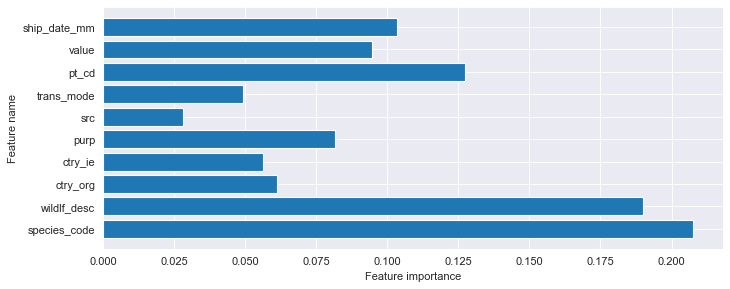

In [19]:
start = datetime.now()
decision_tree_clf = DecisionTreeClassifier(random_state=rng).fit(X_train, y_train)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
tree_predicted = decision_tree_clf.predict(X_test)
confusion = confusion_matrix(y_test, tree_predicted)
if outputs:
    print('Decision Tree classifier (balanced)\n', confusion)
plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(decision_tree_clf, feature_cols)
if outputs:
    plt.show()
    print('Feature importances: {}'.format(decision_tree_clf.feature_importances_[::-1]))

In [20]:
joblib.dump(decision_tree_clf, f'{prefix}_decision_tree_clf.joblib')

['export_run5_TargetEncoding_resampling/export_decision_tree_clf.joblib']

#### Random Forest

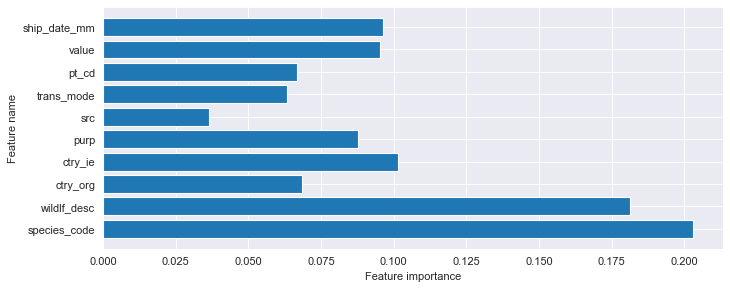

In [21]:
start = datetime.now()
rf_clf = RandomForestClassifier(random_state=rng).fit(X_train, y_train)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
rf_predicted = rf_clf.predict(X_test)
confusion = confusion_matrix(y_test, rf_predicted)
if outputs:
    print('Random Forest classifier (balanced)\n', confusion)
plt.figure(figsize=(10,4), dpi=80)
plot_feature_importances(rf_clf, feature_cols)
if outputs:
    plt.show()
    print('Feature importances: {}'.format(rf_clf.feature_importances_[::-1]))

In [22]:
joblib.dump(rf_clf, f'{prefix}_rf_clf.joblib')

['export_run5_TargetEncoding_resampling/export_rf_clf.joblib']

#### XGBoost Classifier
(default settings)

In [23]:
start = datetime.now()
xgb_params = {"seed": rng }
xgb_clf = xgb.XGBClassifier(random_state = rng).fit(X_train,y_train)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
xgb_predicted = xgb_clf.predict(X_test)
confusion = confusion_matrix(y_test, xgb_predicted)
if outputs:
    print('XGB Classifier Confusion Matrix\n', confusion)

C:\Users\joshh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:17:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [24]:
joblib.dump(rf_clf, f'{prefix}_xgb_clf.joblib')

['export_run5_TargetEncoding_resampling/export_xgb_clf.joblib']

#### FIGS

In [25]:
start = datetime.now()
figs_clf = FIGSClassifier(random_state=rng).fit(X_train,y_train)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
figs_predicted = figs_clf.predict(X_test)
confusion = confusion_matrix(y_test, figs_predicted)
if outputs:
    print('FIGS Classifier Confusion Matrix\n', confusion)

In [26]:
joblib.dump(rf_clf, f'{prefix}_figs_clf.joblib')

['export_run5_TargetEncoding_resampling/export_figs_clf.joblib']

#### LGBM

In [27]:
# light gbm with default params (this thing has a LOT of customization options fyi)
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html
start = datetime.now()
lgbm_model = lgb.LGBMClassifier().fit(X_train, y_train, eval_set=[(X_test,y_test),(X_train,y_train)])
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
lgbm_predicted = lgbm_model.predict(X_test)
confusion = confusion_matrix(y_test, lgbm_predicted)
if outputs:
    print('LightLGBM Classifier Confusion Matrix\n', confusion)

[1]	training's binary_logloss: 0.0357043	valid_0's binary_logloss: 0.0392839
[2]	training's binary_logloss: 0.033794	valid_0's binary_logloss: 0.0384049
[3]	training's binary_logloss: 0.0326437	valid_0's binary_logloss: 0.0379268
[4]	training's binary_logloss: 0.0316441	valid_0's binary_logloss: 0.0372832
[5]	training's binary_logloss: 0.0306088	valid_0's binary_logloss: 0.0368207
[6]	training's binary_logloss: 0.0298931	valid_0's binary_logloss: 0.0364894
[7]	training's binary_logloss: 0.0292776	valid_0's binary_logloss: 0.0362365
[8]	training's binary_logloss: 0.0287615	valid_0's binary_logloss: 0.0359911
[9]	training's binary_logloss: 0.0282274	valid_0's binary_logloss: 0.0357767
[10]	training's binary_logloss: 0.0278203	valid_0's binary_logloss: 0.0356025
[11]	training's binary_logloss: 0.0273304	valid_0's binary_logloss: 0.0353891
[12]	training's binary_logloss: 0.0268443	valid_0's binary_logloss: 0.0350994
[13]	training's binary_logloss: 0.0264404	valid_0's binary_logloss: 0.0349

In [28]:
joblib.dump(rf_clf, f'{prefix}_lgbm_clf.joblib')

['export_run5_TargetEncoding_resampling/export_lgbm_clf.joblib']

#### Model Evaluation

In [29]:
if outputs:
    print('Most frequent class (dummy classifier) \n',
          classification_report(y_test, dummy_predicted, target_names=['clear', 'seized']))
    print('Logistic Regression \n',
          classification_report(y_test, lr_predicted, target_names=['clear', 'seized']))
    print('Logistic Regression (balanced) \n',
          classification_report(y_test, lr_balanced_predicted, target_names=['clear', 'seized']))
    print('Decision Tree \n',
          classification_report(y_test, tree_predicted, target_names=['clear', 'seized']))
    print('Random Forest \n',
          classification_report(y_test, rf_predicted, target_names=['clear', 'seized']))
    print('XGBoost Classifier \n',
          classification_report(y_test, xgb_predicted, target_names=['clear', 'seized']))
    print('FIGS Classifier \n',
          classification_report(y_test, figs_predicted, target_names=['clear', 'seized']))
    print("LGBM Classifier \n",
          classification_report(y_test, lgbm_predicted, target_names=['clear', 'seized']))

In [30]:
# Accuracy = TP + TN / (TP + TN + FP + FN)
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)  Also known as sensitivity, or True Positive Rate
# F1 = 2 * Precision * Recall / (Precision + Recall)

## Resampled Data

In [31]:
# dummy classifier
start = datetime.now()
dummy_majority_resampled = DummyClassifier(strategy = 'most_frequent').fit(X_train_resampled, y_train_resampled)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')

# dummy_majority.score(X_test, y_test)
dummy_predicted_resampled = dummy_majority_resampled.predict(X_test)
joblib.dump(dummy_majority, f'{prefix}_dummy_majority_clf_resampled.joblib')

['export_run5_TargetEncoding_resampling/export_dummy_majority_clf_resampled.joblib']

In [32]:
# logistic regression
start = datetime.now()
lr_resampled = LogisticRegression(random_state=rng, max_iter=1000).fit(X_train_resampled, y_train_resampled)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
lr_predicted_resampled = lr_resampled.predict(X_test)
confusion = confusion_matrix(y_test, lr_predicted_resampled, labels=[1, 0])
if outputs:
    print('Logistic regression classifier resampled (default settings)\n', confusion)
cm_display = ConfusionMatrixDisplay(confusion, display_labels=[1, 0])
if outputs:
    cm_display.plot()

In [33]:
# balanced logistic regression
start = datetime.now()
lr_balanced_resampled = LogisticRegression(random_state=rng, class_weight='balanced', max_iter=1000).fit(X_train_resampled, y_train_resampled)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
lr_balanced_predicted_resampled = lr_balanced.predict(X_test)
confusion = confusion_matrix(y_test, lr_balanced_predicted_resampled)
if outputs:
    print('Logistic regression classifier resampled (balanced)\n', confusion)

In [34]:
joblib.dump(lr_resampled, f'{prefix}_lr_clf_resampled.joblib')
joblib.dump(lr_balanced_resampled, f'{prefix}_lr_balanced_clf_resampled.joblib')

['export_run5_TargetEncoding_resampling/export_lr_balanced_clf_resampled.joblib']

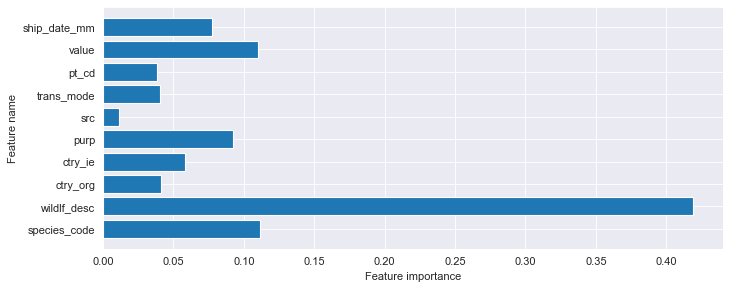

In [35]:
# decision tree
start = datetime.now()
decision_tree_clf_resampled = DecisionTreeClassifier(random_state=rng).fit(X_train_resampled, y_train_resampled)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
tree_predicted_resampled = decision_tree_clf_resampled.predict(X_test)
confusion = confusion_matrix(y_test, tree_predicted_resampled)
if outputs:
    print('Decision Tree classifier resampled\n', confusion)
plt.figure(figsize=(10, 4), dpi=80)
plot_feature_importances(decision_tree_clf_resampled, feature_cols)
if outputs:
    plt.show()
    print('Feature importances: {}'.format(decision_tree_clf_resampled.feature_importances_[::-1]))

In [36]:
joblib.dump(decision_tree_clf_resampled, f'{prefix}_decision_tree_clf_resampled.joblib')

['export_run5_TargetEncoding_resampling/export_decision_tree_clf_resampled.joblib']

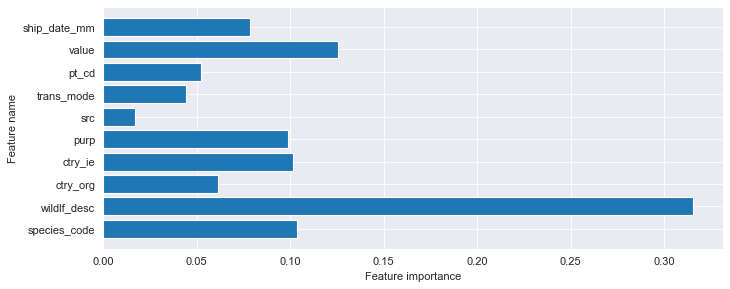

In [37]:
# random forest
start = datetime.now()
rf_clf_resampled = RandomForestClassifier(random_state=rng).fit(X_train_resampled, y_train_resampled)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
rf_predicted_resampled = rf_clf_resampled.predict(X_test)
confusion = confusion_matrix(y_test, rf_predicted_resampled)
if outputs:
    print('Random Forest classifier (balanced)\n', confusion)
plt.figure(figsize=(10, 4), dpi=80)
plot_feature_importances(rf_clf_resampled, feature_cols)
if outputs:
    plt.show()
    print('Feature importances: {}'.format(rf_clf_resampled.feature_importances_[::-1]))

In [38]:
joblib.dump(rf_clf, f'{prefix}_rf_clf_resampled.joblib')

['export_run5_TargetEncoding_resampling/export_rf_clf_resampled.joblib']

In [39]:
# xgboost
start = datetime.now()
xgb_params = {"seed": rng}
xgb_clf_resampled = xgb.XGBClassifier(random_state=rng).fit(X_train_resampled, y_train_resampled)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
xgb_predicted_resampled = xgb_clf_resampled.predict(X_test)
confusion = confusion_matrix(y_test, xgb_predicted_resampled)
if outputs:
    print('XGB Classifier Resampled Confusion Matrix\n', confusion)
joblib.dump(rf_clf_resampled, f'{prefix}_xgb_clf_resampled.joblib')

C:\Users\joshh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


['export_run5_TargetEncoding_resampling/export_xgb_clf_resampled.joblib']

In [40]:
# figs
start = datetime.now()
figs_clf_resampled = FIGSClassifier(random_state=rng).fit(X_train_resampled, y_train_resampled)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
figs_predicted_resampled = figs_clf_resampled.predict(X_test)
confusion = confusion_matrix(y_test, figs_predicted_resampled)
if outputs:
    print('FIGS Classifier Resampled Confusion Matrix\n', confusion)
joblib.dump(rf_clf, f'{prefix}_figs_clf_resampled.joblib')

['export_run5_TargetEncoding_resampling/export_figs_clf_resampled.joblib']

In [41]:
#lightgbm
start = datetime.now()
lgbm_model_resampled = lgb.LGBMClassifier().fit(X_train_resampled, y_train_resampled, eval_set=[(X_test, y_test),
                                                                                      (X_train_resampled, y_train_resampled)])
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
lgbm_predicted_resampled = lgbm_model_resampled.predict(X_test)
confusion = confusion_matrix(y_test, lgbm_predicted_resampled)
if outputs:
    print('LightLGBM Classifier Resampled Confusion Matrix\n', confusion)
joblib.dump(rf_clf, f'{prefix}_lgbm_clf_resampled.joblib')

[1]	training's binary_logloss: 0.640436	valid_0's binary_logloss: 0.641452
[2]	training's binary_logloss: 0.597086	valid_0's binary_logloss: 0.598867
[3]	training's binary_logloss: 0.560913	valid_0's binary_logloss: 0.563358
[4]	training's binary_logloss: 0.530109	valid_0's binary_logloss: 0.5331
[5]	training's binary_logloss: 0.503827	valid_0's binary_logloss: 0.507489
[6]	training's binary_logloss: 0.479967	valid_0's binary_logloss: 0.48384
[7]	training's binary_logloss: 0.459746	valid_0's binary_logloss: 0.46367
[8]	training's binary_logloss: 0.441787	valid_0's binary_logloss: 0.446019
[9]	training's binary_logloss: 0.42581	valid_0's binary_logloss: 0.430115
[10]	training's binary_logloss: 0.411333	valid_0's binary_logloss: 0.415911
[11]	training's binary_logloss: 0.39832	valid_0's binary_logloss: 0.403181
[12]	training's binary_logloss: 0.386786	valid_0's binary_logloss: 0.391729
[13]	training's binary_logloss: 0.376408	valid_0's binary_logloss: 0.381867
[14]	training's binary_logl

['export_run5_TargetEncoding_resampling/export_lgbm_clf_resampled.joblib']

## SMOTE Data

In [42]:
# dummy classifier
start = datetime.now()
dummy_majority_smote = DummyClassifier(strategy = 'most_frequent').fit(X_train_SMOTE, y_train_SMOTE)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')

# dummy_majority.score(X_test, y_test)
dummy_predicted_smote = dummy_majority_smote.predict(X_test)
joblib.dump(dummy_majority, f'{prefix}_dummy_majority_clf_smote.joblib')

['export_run5_TargetEncoding_resampling/export_dummy_majority_clf_smote.joblib']

In [43]:
# logistic regression
start = datetime.now()
lr_smote = LogisticRegression(random_state=rng, max_iter=1000).fit(X_train_SMOTE, y_train_SMOTE)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
lr_predicted_smote = lr_smote.predict(X_test)
confusion = confusion_matrix(y_test, lr_predicted_smote, labels=[1, 0])
if outputs:
    print('Logistic regression classifier SMOTE (default settings)\n', confusion)
cm_display = ConfusionMatrixDisplay(confusion, display_labels=[1, 0])
if outputs:
    cm_display.plot()

In [44]:
# balanced logistic regression
start = datetime.now()
lr_balanced_smote = LogisticRegression(random_state=rng, class_weight='balanced', max_iter=1000).fit(
    X_train_SMOTE, y_train_SMOTE)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
lr_balanced_predicted_smote = lr_balanced_smote.predict(X_test)
confusion = confusion_matrix(y_test, lr_balanced_predicted_smote)
if outputs:
    print('Logistic regression classifier SMOTE (balanced)\n', confusion)

In [45]:
joblib.dump(lr_smote, f'{prefix}_lr_clf_smote.joblib')
joblib.dump(lr_balanced_smote, f'{prefix}_lr_balanced_clf_smote.joblib')

['export_run5_TargetEncoding_resampling/export_lr_balanced_clf_smote.joblib']

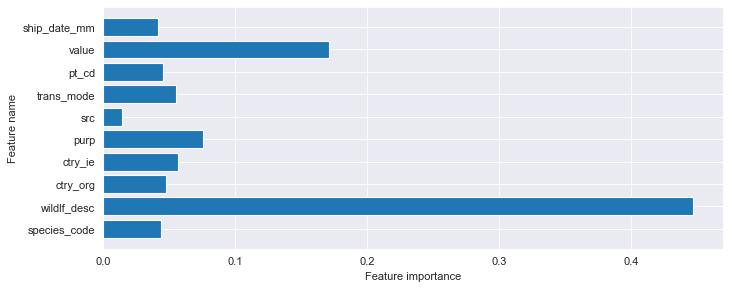

In [46]:
# decision tree
start = datetime.now()
decision_tree_clf_smote = DecisionTreeClassifier(random_state=rng).fit(X_train_SMOTE, y_train_SMOTE)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
tree_predicted_smote = decision_tree_clf_smote.predict(X_test)
confusion = confusion_matrix(y_test, tree_predicted_smote)
if outputs:
    print('Decision Tree classifier SMOTE\n', confusion)
plt.figure(figsize=(10, 4), dpi=80)
plot_feature_importances(decision_tree_clf_smote, feature_cols)
if outputs:
    plt.show()
    print('Feature importances: {}'.format(decision_tree_clf_smote.feature_importances_[::-1]))

In [47]:
joblib.dump(decision_tree_clf_smote, f'{prefix}_decision_tree_clf_smote.joblib')

['export_run5_TargetEncoding_resampling/export_decision_tree_clf_smote.joblib']

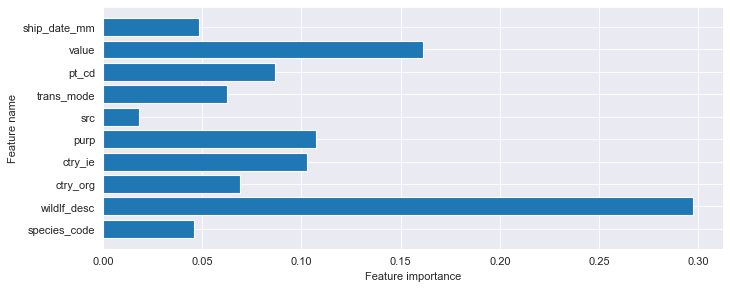

In [48]:
# random forest
start = datetime.now()
rf_clf_smote = RandomForestClassifier(random_state=rng).fit(X_train_SMOTE, y_train_SMOTE)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
rf_predicted_smote = rf_clf_smote.predict(X_test)
confusion = confusion_matrix(y_test, rf_predicted_smote)
if outputs:
    print('Logistic regression classifier (balanced)\n', confusion)
plt.figure(figsize=(10, 4), dpi=80)
plot_feature_importances(rf_clf_smote, feature_cols)
if outputs:
    plt.show()
    print('Feature importances: {}'.format(rf_clf_smote.feature_importances_[::-1]))

In [49]:
joblib.dump(rf_clf, f'{prefix}_rf_clf_smote.joblib')

['export_run5_TargetEncoding_resampling/export_rf_clf_smote.joblib']

In [50]:
# xgboost
start = datetime.now()
xgb_params = {"seed": rng}
xgb_clf_smote = xgb.XGBClassifier(random_state=rng).fit(X_train_SMOTE, y_train_SMOTE)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
xgb_predicted_smote = xgb_clf_smote.predict(X_test)
confusion = confusion_matrix(y_test, xgb_predicted_smote)
if outputs:
    print('XGB Classifier SMOTE Confusion Matrix\n', confusion)
joblib.dump(rf_clf_smote, f'{prefix}_xgb_clf_resampled.joblib')

C:\Users\joshh\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:20:22] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


['export_run5_TargetEncoding_resampling/export_xgb_clf_resampled.joblib']

In [51]:
# figs
start = datetime.now()
figs_clf_smote = FIGSClassifier(random_state=rng).fit(X_train_SMOTE, y_train_SMOTE)
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
figs_predicted_smote = figs_clf_smote.predict(X_test)
confusion = confusion_matrix(y_test, figs_predicted_smote)
if outputs:
    print('FIGS Classifier SMOTE Confusion Matrix\n', confusion)
joblib.dump(rf_clf, f'{prefix}_figs_clf_smote.joblib')

['export_run5_TargetEncoding_resampling/export_figs_clf_smote.joblib']

In [52]:
#lightgbm
start = datetime.now()
lgbm_model_smote = lgb.LGBMClassifier().fit(X_train_SMOTE, y_train_SMOTE, eval_set=[(X_test, y_test),
                                                                                    (X_train_SMOTE, y_train_SMOTE)])
end = datetime.now()
if outputs:
    print(f'model run time: {end - start}')
lgbm_predicted_smote = lgbm_model_smote.predict(X_test)
confusion = confusion_matrix(y_test, lgbm_predicted_smote)
if outputs:
    print('LightLGBM Classifier SMOTE Confusion Matrix\n', confusion)
joblib.dump(rf_clf, f'{prefix}_lgbm_clf_smote.joblib')

[1]	training's binary_logloss: 0.632419	valid_0's binary_logloss: 0.633205
[2]	training's binary_logloss: 0.583411	valid_0's binary_logloss: 0.585307
[3]	training's binary_logloss: 0.541586	valid_0's binary_logloss: 0.544074
[4]	training's binary_logloss: 0.505381	valid_0's binary_logloss: 0.508587
[5]	training's binary_logloss: 0.474014	valid_0's binary_logloss: 0.47793
[6]	training's binary_logloss: 0.44598	valid_0's binary_logloss: 0.45084
[7]	training's binary_logloss: 0.420805	valid_0's binary_logloss: 0.426724
[8]	training's binary_logloss: 0.398979	valid_0's binary_logloss: 0.405872
[9]	training's binary_logloss: 0.379669	valid_0's binary_logloss: 0.386986
[10]	training's binary_logloss: 0.36188	valid_0's binary_logloss: 0.369729
[11]	training's binary_logloss: 0.346036	valid_0's binary_logloss: 0.35472
[12]	training's binary_logloss: 0.331462	valid_0's binary_logloss: 0.340525
[13]	training's binary_logloss: 0.318182	valid_0's binary_logloss: 0.327432
[14]	training's binary_log

['export_run5_TargetEncoding_resampling/export_lgbm_clf_smote.joblib']

## Overall Data Comparison

In [53]:
if outputs:
    # dummy
    print('Most frequent class standard(dummy classifier) \n',
          classification_report(y_test, dummy_predicted, target_names=['clear', 'seized']))
    print('Most frequent class resampled (dummy classifier) \n',
          classification_report(y_test, dummy_predicted_resampled, target_names=['clear', 'seized']))
    print('Most frequent class SMOTE (dummy classifier) \n',
          classification_report(y_test, dummy_predicted_smote, target_names=['clear', 'seized']))\
    # logistic regression
    print('Logistic Regression standard \n',
          classification_report(y_test, lr_predicted, target_names=['clear', 'seized']))
    print('Logistic Regression resampled \n',
          classification_report(y_test, lr_predicted_resampled, target_names=['clear', 'seized']))
    print('Logistic Regression SMOTE \n',
          classification_report(y_test, lr_predicted_smote, target_names=['clear', 'seized']))
    # logistic regression balanced
    print('Logistic Regression (balanced) \n',
          classification_report(y_test, lr_balanced_predicted, target_names=['clear', 'seized']))
    print('Logistic Regression resampled (balanced) \n',
          classification_report(y_test, lr_balanced_predicted_resampled, target_names=['clear', 'seized']))
    print('Logistic Regression SMOTE (balanced) \n',
          classification_report(y_test, lr_balanced_predicted_smote, target_names=['clear', 'seized']))
    # decision tree
    print('Decision Tree \n',
          classification_report(y_test, tree_predicted, target_names=['clear', 'seized']))
    print('Decision Tree resampled \n',
          classification_report(y_test, tree_predicted_resampled, target_names=['clear', 'seized']))
    print('Decision Tree SMOTE \n',
          classification_report(y_test, tree_predicted_smote, target_names=['clear', 'seized']))
    # random forest
    print('Random Forest \n',
          classification_report(y_test, rf_predicted, target_names=['clear', 'seized']))
    print('Random Forest resampled \n',
          classification_report(y_test, rf_predicted_resampled, target_names=['clear', 'seized']))
    print('Random Forest SMOTE \n',
          classification_report(y_test, rf_predicted_smote, target_names=['clear', 'seized']))
    # XGBoost
    print('XGBoost Classifier \n',
          classification_report(y_test, xgb_predicted, target_names=['clear', 'seized']))
    print('XGBoost Classifier resampled \n',
          classification_report(y_test, xgb_predicted_resampled, target_names=['clear', 'seized']))
    print('XGBoost Classifier SMOTE \n',
          classification_report(y_test, xgb_predicted_resampled, target_names=['clear', 'seized']))
    # FIGS
    print('FIGS Classifier \n',
          classification_report(y_test, figs_predicted, target_names=['clear', 'seized']))
    print('FIGS Classifier resampled\n',
          classification_report(y_test, figs_predicted_resampled, target_names=['clear', 'seized']))
    print('FIGS Classifier SMOTE\n',
          classification_report(y_test, figs_predicted_smote, target_names=['clear', 'seized']))
    # LGBM
    print("LGBM Classifier \n",
          classification_report(y_test, lgbm_predicted, target_names=['clear', 'seized']))
    print("LGBM Classifier resampled \n",
          classification_report(y_test, lgbm_predicted_resampled, target_names=['clear', 'seized']))
    print("LGBM Classifier SMOTE \n",
          classification_report(y_test, lgbm_predicted_smote, target_names=['clear', 'seized']))

In [70]:
X_train_lgbm.columns.to_list()

['species_code',
 'wildlf_desc',
 'ctry_org',
 'ctry_ie',
 'purp',
 'src',
 'trans_mode',
 'pt_cd',
 'value',
 'ship_date_mm']

In [71]:
X_train_lgbm, X_test_lgbm, y_train_lgbm, y_test_lgbm = data_split(export_df)

start = datetime.now()
lgbm_model_raw= lgb.LGBMClassifier(feature_name= X_train_lgbm.columns.to_list(), categorical_feature= ["species_code", "wildlf_desc", "ctry_org",
                                                                                             "ctry_ie", "purp",
                                                         "src", "trans_mode", "pt_cd"]).fit(X_train_lgbm, y_train_lgbm, eval_set=[(X_test_lgbm, y_test_lgbm),
                                                                                    (X_train_lgbm, y_train_lgbm)])
end = datetime.now()

print(f'model run time: {end - start}')
lgbm_predicted_raw = lgbm_model_raw.predict(X_test)
confusion = confusion_matrix(y_test, lgbm_predicted_raw)
print('LightLGBM Classifier SMOTE Confusion Matrix\n', confusion)

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in the following fields: species_code, wildlf_desc, ctry_org, ctry_ie, purp, src, trans_mode, pt_cd

## PCA Validation via Truncated SVD

In [54]:
from sklearn.decomposition import TruncatedSVD

test_standard = TruncatedSVD(n_components=5, random_state=rng)
X_train_svd = test_standard.fit_transform(X_train)
[feature_cols[i] for i in test_standard.components_[0].argsort()[::-1]]

['ship_date_mm',
 'src',
 'value',
 'pt_cd',
 'purp',
 'ctry_org',
 'wildlf_desc',
 'trans_mode',
 'ctry_ie',
 'species_code']

In [58]:
test_standard.__dict__

{'algorithm': 'randomized',
 'n_components': 5,
 'n_iter': 5,
 'n_oversamples': 10,
 'power_iteration_normalizer': 'auto',
 'random_state': 42,
 'tol': 0.0,
 'n_features_in_': 10,
 'components_': array([[-1.45610663e-03,  1.08024816e-03,  1.08052940e-03,
          1.04437999e-03,  1.08298093e-03,  1.09704038e-03,
          1.05485817e-03,  1.09229473e-03,  1.09481920e-03,
          9.99994287e-01],
        [ 9.99995946e-01,  4.25736633e-04,  5.07853487e-04,
          2.32226143e-03,  9.09747873e-05,  2.32893707e-05,
          3.58514930e-04, -1.68756876e-04, -3.74771327e-06,
          1.45236123e-03],
        [-1.47667402e-03,  8.29078462e-01,  1.12190155e-01,
          4.07918398e-01,  3.80115120e-02,  3.72052065e-02,
          3.53509476e-01,  5.02917393e-02,  5.75438117e-02,
         -2.01783596e-03],
        [ 1.32601542e-03,  5.49616772e-01, -2.68053720e-02,
         -5.74840242e-01, -2.45266453e-02, -1.71055762e-02,
         -6.03165001e-01, -3.65502348e-02, -2.68532710e-02,
    

In [55]:
test_resampled = TruncatedSVD(n_components=5, random_state=rng)
X_train_svd_resampled = test_resampled.fit_transform(X_train_resampled)
[feature_cols[i] for i in test_resampled.components_[0].argsort()[::-1]]

['ship_date_mm',
 'wildlf_desc',
 'ctry_ie',
 'trans_mode',
 'ctry_org',
 'value',
 'pt_cd',
 'purp',
 'src',
 'species_code']

In [59]:
test_resampled.__dict__

{'algorithm': 'randomized',
 'n_components': 5,
 'n_iter': 5,
 'n_oversamples': 10,
 'power_iteration_normalizer': 'auto',
 'random_state': 42,
 'tol': 0.0,
 'n_features_in_': 10,
 'components_': array([[-3.13138159e-03,  9.03823479e-03,  2.01720799e-03,
          4.74969914e-03,  1.37427207e-03,  1.27004647e-03,
          4.61986056e-03,  1.62636040e-03,  1.89117869e-03,
          9.99925402e-01],
        [ 9.99980432e-01,  3.23385707e-03,  7.97151792e-04,
         -2.10604445e-03, -1.07714198e-04, -2.66043758e-04,
         -3.43332939e-03, -1.00670452e-03, -9.61191401e-04,
          3.13052301e-03],
        [-1.49836901e-03,  9.25499873e-01,  6.98694844e-02,
          2.60483372e-01,  1.62606712e-02,  1.39529412e-02,
          2.60294347e-01,  3.71140598e-02,  3.16425725e-02,
         -1.11113586e-02],
        [ 5.01566193e-03, -3.70699684e-01,  2.06624899e-02,
          5.58369098e-01,  1.01021201e-02,  9.20461828e-03,
          7.37224953e-01,  6.23533758e-02,  5.26258766e-02,
    

In [56]:
test_smote = TruncatedSVD(n_components=5, random_state=rng)
X_train_svd_smote = test_smote.fit_transform(X_train_SMOTE)
[feature_cols[i] for i in test_smote.components_[0].argsort()[::-1]]

['ship_date_mm',
 'wildlf_desc',
 'ctry_ie',
 'trans_mode',
 'ctry_org',
 'value',
 'pt_cd',
 'purp',
 'src',
 'species_code']

In [60]:
test_smote.__dict__

{'algorithm': 'randomized',
 'n_components': 5,
 'n_iter': 5,
 'n_oversamples': 10,
 'power_iteration_normalizer': 'auto',
 'random_state': 42,
 'tol': 0.0,
 'n_features_in_': 10,
 'components_': array([[-3.55392410e-03,  8.89407259e-03,  1.87289937e-03,
          4.80073518e-03,  1.34526897e-03,  1.24940019e-03,
          4.60734845e-03,  1.62754314e-03,  1.81223000e-03,
          9.99925587e-01],
        [ 9.99978978e-01,  2.95917037e-03,  7.60164146e-04,
         -2.31113623e-03, -1.10687942e-04, -2.56814156e-04,
         -3.57719361e-03, -1.01191028e-03, -9.00747166e-04,
          3.55769693e-03],
        [-1.05589874e-03,  9.19625799e-01,  6.05017490e-02,
          2.69731500e-01,  1.55259893e-02,  1.36272571e-02,
          2.74057392e-01,  3.86146208e-02,  2.69320681e-02,
         -1.10042577e-02],
        [ 5.14920470e-03, -3.86921939e-01,  1.92903222e-02,
          5.61236149e-01,  1.10731172e-02,  7.78924296e-03,
          7.26816876e-01,  6.43857340e-02,  4.80327261e-02,
    